# Preambule

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import robust_scale
from sqlalchemy import create_engine
from astropy.io import fits

In [ ]:
from castor import spec2sqr

In [4]:
from ipywidgets import IntProgress
from IPython.display import display

In [5]:
%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["image.cmap"] = "hsv"

## Load table into dataframe

In [5]:
names = ['obsid', 'designation', 'obsdate', 'lmjd', 'mjd', 'planid', 'spid', 'fiberid', 'ra_obs', 'dec_obs',
         'snru', 'snrg', 'snrr', 'snri', 'snrz', 'objtype', 'class', 'subclass', 'z', 'z_err', 'magtype',
         'mag1', 'mag2', 'mag3', 'mag4', 'mag5', 'mag6', 'mag7', 'tsource', 'fibertype', 'tfrom', 'tcomment',
         'offsets', 'offset_v', 'ra', 'dec', 'teff', 'teff_err', 'logg', 'logg_err', 'feh', 'feh_err', 'rv', 'rv_err']

In [6]:
data = pd.read_csv("catalog/dr5_v1_stellar.csv.gz",
#                   header=None, names=names, skiprows=1,
                   sep="|", na_values=[-9999.00, "NULL"],
                   low_memory=False)

In [7]:
basename = data["mjd"].map("spec-{}-".format)\
         + data["planid"].map("{}".format)\
         + data["spid"].map("_sp{:02d}-".format)\
         + data["fiberid"].map("{:03d}".format)
data["basename"] = basename

In [8]:
data.describe()

,obsid,lmjd,mjd,spid,fiberid,ra_obs,dec_obs,snru,snrg,snrr,...,ra,dec,teff,teff_err,logg,logg_err,feh,feh_err,rv,rv_err
count,5.344058e+06,5.344058e+06,5.344058e+06,5.344058e+06,5.344058e+06,5.344058e+06,5.344058e+06,5.344058e+06,5.344058e+06,5.344058e+06,...,5.344058e+06,5.344058e+06,5.344058e+06,5.337995e+06,5.344058e+06,5.328851e+06,5.344058e+06,5.339330e+06,5.344058e+06,5.340785e+06
mean,2.799975e+08,5.693612e+04,5.693512e+04,8.427821e+00,1.261698e+02,1.466621e+02,2.642608e+01,1.043125e+01,5.347465e+01,8.718831e+01,...,1.466621e+02,2.642608e+01,5.558844e+03,1.222823e+02,4.001565e+00,1.926714e-01,-2.420500e-01,1.156230e-01,-8.565519e+00,6.845266e+00
std,1.552318e+08,5.576247e+02,5.576247e+02,4.575126e+00,7.085453e+01,9.190012e+01,1.657003e+01,1.670946e+01,5.653408e+01,8.456369e+01,...,9.190012e+01,1.657003e+01,7.537603e+02,1.139905e+02,6.993862e-01,1.690037e-01,3.448223e-01,1.076183e-01,4.619547e+01,5.704349e+00
min,1.010010e+05,5.585900e+04,5.585800e+04,1.000000e+00,1.000000e+00,9.500000e-05,-9.821160e+00,0.000000e+00,6.000000e-01,0.000000e+00,...,9.500000e-05,-9.821160e+00,3.459900e+03,2.570000e+00,-1.620000e-01,2.000000e-03,-2.499000e+00,2.000000e-03,-4.993500e+02,3.000000e-02
25%,1.576112e+08,5.655100e+04,5.655000e+04,4.000000e+00,6.500000e+01,7.950510e+01,1.360151e+01,1.800000e+00,1.944000e+01,3.468000e+01,...,7.950510e+01,1.360152e+01,4.989510e+03,3.845000e+01,3.926000e+00,6.300000e-02,-4.220000e-01,3.600000e-02,-3.268000e+01,4.370000e+00
50%,2.665151e+08,5.697600e+04,5.697500e+04,8.000000e+00,1.260000e+02,1.240498e+02,2.728168e+01,4.800000e+00,3.571000e+01,6.182000e+01,...,1.240498e+02,2.728168e+01,5.601790e+03,8.552000e+01,4.192000e+00,1.400000e-01,-2.020000e-01,8.200000e-02,-8.080000e+00,5.540000e+00
75%,4.056032e+08,5.739900e+04,5.739800e+04,1.200000e+01,1.870000e+02,2.101537e+02,3.953160e+01,1.203000e+01,6.625000e+01,1.088500e+02,...,2.101537e+02,3.953160e+01,6.035630e+03,1.755500e+02,4.440000e+00,2.770000e-01,-1.100000e-02,1.650000e-01,1.720000e+01,7.530000e+00
max,5.852162e+08,5.792100e+04,5.792000e+04,1.600000e+01,2.500000e+02,3.599999e+02,6.284092e+01,4.715000e+02,9.990000e+02,9.990000e+02,...,3.599999e+02,6.284092e+01,8.499940e+03,9.999800e+02,4.900000e+00,1.200000e+00,9.980000e-01,1.000000e+00,4.980700e+02,1.000000e+02


## Simple Query Language

In [13]:
#eng = create_engine("sqlite:///lamost.db")
tip = ["teff", "logg", "feh"]
top = ["teff_err", "logg_err", "feh_err"]
#sql = "SELECT {} FROM dr5"\
#      .format(",".join(["basename"]+tip+top))
#dat = pd.read_sql(sql, eng)

In [9]:
dat = data

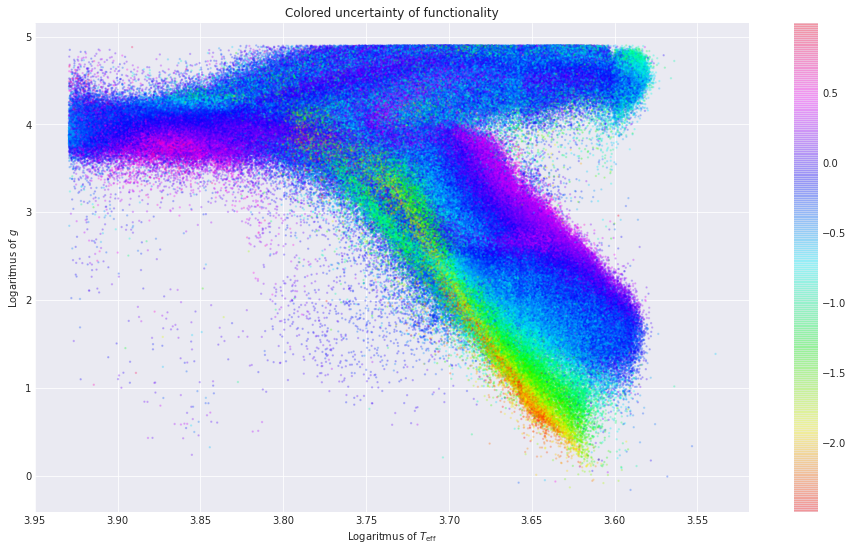

In [10]:
plt.title("Colored uncertainty of functionality")
plt.xlabel("Logaritmus of $T_\mathrm{eff}$")
plt.ylabel("Logaritmus of $g$")
plt.scatter(np.log10(dat["teff"]), dat["logg"],
            s=2, c=dat["feh"], alpha=0.2);
plt.gca().invert_xaxis()
plt.colorbar();

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


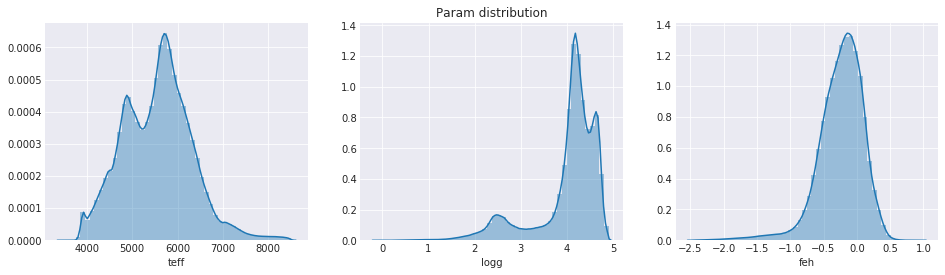

In [14]:
plt.figure(figsize=(16,4))
for i, name in enumerate(tip):
    if i == 2: plt.title("Param distribution")
    plt.subplot(131+i)
    plt.xlabel(tip[i])
    sns.distplot(dat[name])

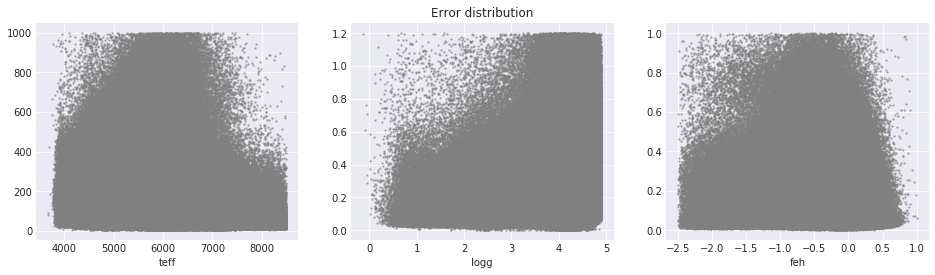

In [15]:
plt.figure(figsize=(16,4))
for i, name in enumerate(tip):
    if i == 2: plt.title("Error distribution")
    plt.subplot(131+i)
    plt.xlabel(tip[i])
    plt.scatter(dat[tip[i]], dat[top[i]],
               s=2, c="gray", alpha=0.5)

## Download

In [39]:
len(data) // 1e5

53.0

In [42]:
100000 % 100000

0

In [43]:
#```python
URL = "http://dr5.lamost.org/spectrum/fits/"
prog = IntProgress(min=0, max=len(data)); display(prog)
with open("lamost.url", "w") as file:
    for i in range(len(data)):
        line = data.iloc[i]
        URI = URL + str(line["obsid"])
        BASE = "/space/janak/LAMOST/"
        DIRS = "dr5-v1/" + str(line["planid"])
        FITS = line["basename"] + ".fits.gz"
        FULL = os.path.join(BASE, DIRS, FITS)
        if not os.path.exists(DIRS):
            os.mkdir(DIRS)
        if not os.path.exists(FULL):
            file.write("wget -O {0} {1}\n"
                       .format(FULL, URI))
        if i % 1e5 == 0: prog.value = i;
#```

IntProgress(value=0, max=5344058)

In [ ]:
# stvoření lamostu z obsahu vzorku
with open("lamost.lst", "w") as last:
    filenames = glob.glob("/mnt/arch/LAMOST/dr5-v1/sample/*.fits")
    for funy in filenames:
        name = os.path.basename(funy.strip(".fits\n"))
        last.write(name+"\n")

## Spectral normalization

In [ ]:
lamost = open("lamost.lst").readlines()
progres = IntProgress(min=0, max=len(lamost))
display(progres)
for name in lamost:
    name = name.strip()
    #if not os.path.exists("lamost/"+name+".npy"):
        #print(name)
    flux = fits.getdata("/mnt/arch/LAMOST/dr5-v1/sample/"+name+".fits")[0]
    sqr = spec2sqr(robust_scale(flux.reshape(-1,1)), a=64)
    np.save("lamost/"+name+".npy", sqr)
    progres.value += 1

## Preview

In [ ]:
lamost = open("lamost.lst").readlines()
lama = np.random.randint(len(lamost))
name = lamost[lama].strip()
path = "/mnt/arch/LAMOST/dr5/sample/"+name+".fits"
flux = fits.getdata(path)[0]
N = fits.getval(path, "NAXIS1")
l = fits.getval(path, "CRVAL1")
s = fits.getval(path, "CD1_1")
wave = np.logspace(l, l+N*s, N)
wave.shape, wave.min(), wave.max()

In [ ]:
plt.figure(figsize=(16,5))
plt.title("Lamost dr1 sample spectrum")
plt.xlabel("Wavelength [Ä]")
plt.ylabel("Flux")
plt.scatter(wave, flux, c=flux, s=5)

In [ ]:
# zápis předpokládaných výsledků
eng = create_engine("sqlite:///lamost.db")
most = pd.DataFrame({"basename": open("lamost.lst").readlines()})
most.basename = most.basename.map(str.strip)
merg = most.merge(data)
merg.to_sql("sample", eng, if_exists="replace")
np.save("lamost.npy", merg[tip].values)